### Library Import

In [43]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

### Data Load

In [35]:
# 파일 호출
data_path: str = "../../data"
#print(os.getcwd())
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [36]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:03<00:00, 35.60it/s]


### EDA (Explanatory Data Analysis) + Data Preprocessing

### 1차 클렌징

In [37]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_liquidations_ftx_all_symbol_short_liquidations_usd     100.0
hourly_market-data_open-interest_bitmex_open_interest                     100.0
hourly_market-data_open-interest_all_exchange_open_interest               100.0
hourly_market-data_open-interest_gate_io_open_interest                    100.0
hourly_market-data_open-interest_deribit_open_interest                    100.0
                                                                          ...  
hourly_market-data_open-interest_htx_global_btc_usd_open_interest           0.0
hourly_network-data_transactions-count_transactions_count_total             0.0
target                                                                      0.0
ID                                                                          0.0
hourly_market-data_open-interest_all_exchange_all_symbol_open_interest      0.0
Length: 255, dtype: float64

전부 누락된 컬럼은 제외한 후,
남은 결측치는 linear interpolation으로 대체한다.

In [38]:
essential_features = sorted_missing_percentage[sorted_missing_percentage!=100]
essential_features

hourly_market-data_open-interest_binance_btc_busd_open_interest            1.004566
hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd    1.004566
hourly_market-data_liquidations_binance_btc_busd_long_liquidations         1.004566
hourly_market-data_liquidations_binance_btc_busd_short_liquidations        1.004566
hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd     1.004566
                                                                             ...   
hourly_market-data_open-interest_htx_global_btc_usd_open_interest          0.000000
hourly_network-data_transactions-count_transactions_count_total            0.000000
target                                                                     0.000000
ID                                                                         0.000000
hourly_market-data_open-interest_all_exchange_all_symbol_open_interest     0.000000
Length: 215, dtype: float64

In [39]:
tmp_df = df[essential_features.keys()]
tmp_df

,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,...,hourly_network-data_blockreward_blockreward,hourly_network-data_blockreward_blockreward_usd,hourly_network-data_block-count_block_count,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_transactions-count_transactions_count_total,target,ID,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest
0,3.180371e+08,0.0,0.0,0.0,0.0,0.01,0.411867,2015805.0,1411658.0,1.427970,...,75.561037,1.248565e+06,12.0,16536.747967,5516.420322,3.412540e+07,11457.0,2.0,2023-01-01 00:00:00,6.271344e+09
1,3.183281e+08,0.0,0.0,0.0,0.0,0.01,0.225491,4032601.0,1174054.0,3.434766,...,25.256248,4.176322e+05,4.0,16557.136536,4513.341881,3.456750e+07,5832.0,1.0,2023-01-01 01:00:00,6.288683e+09
2,3.179729e+08,0.0,0.0,0.0,0.0,0.01,0.635430,857595.0,1494750.0,0.573738,...,50.312978,8.321735e+05,8.0,16548.149805,4310.904314,3.452090e+07,5550.0,1.0,2023-01-01 02:00:00,6.286796e+09
3,3.179643e+08,0.0,0.0,0.0,0.0,0.01,0.412550,1237990.0,869405.0,1.423951,...,31.469829,5.199754e+05,5.0,16533.632875,4893.417864,3.438940e+07,5245.0,1.0,2023-01-01 03:00:00,6.284575e+09
4,3.174773e+08,0.0,0.0,0.0,0.0,0.01,0.537532,2423293.0,2816626.0,0.860353,...,44.094866,7.286038e+05,7.0,16524.712159,5209.002297,3.439200e+07,6942.0,2.0,2023-01-01 04:00:00,6.291582e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,NaN,NaN,NaN,NaN,NaN,NaN,0.530275,2287006.0,2581811.0,0.885815,...,11.714916,7.545328e+05,3.0,NaN,NaN,4.281260e+07,10048.0,NaN,2024-04-26 03:00:00,1.486836e+10
11548,NaN,NaN,NaN,NaN,NaN,NaN,0.618616,4852344.0,7870643.0,0.616512,...,22.795398,1.466257e+06,NaN,NaN,NaN,4.275070e+07,NaN,NaN,2024-04-26 04:00:00,NaN
11549,NaN,NaN,NaN,NaN,NaN,NaN,0.511294,8300391.0,8684026.0,0.955823,...,22.502089,1.447081e+06,NaN,NaN,NaN,4.277180e+07,NaN,NaN,2024-04-26 05:00:00,NaN
11550,NaN,NaN,NaN,NaN,NaN,NaN,0.475819,3773806.0,3425631.0,1.101638,...,14.441932,9.307435e+05,NaN,NaN,NaN,4.266640e+07,NaN,NaN,2024-04-26 06:00:00,NaN


In [40]:
tmp_df.interpolate(method='linear', inplace = True)
tmp_df

/tmp/ipykernel_678466/533327767.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  tmp_df.interpolate(method='linear', inplace = True)
/tmp/ipykernel_678466/533327767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.interpolate(method='linear', inplace = True)


,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,...,hourly_network-data_blockreward_blockreward,hourly_network-data_blockreward_blockreward_usd,hourly_network-data_block-count_block_count,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_transactions-count_transactions_count_total,target,ID,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest
0,3.180371e+08,0.0,0.0,0.0,0.0,0.01,0.411867,2015805.0,1411658.0,1.427970,...,75.561037,1.248565e+06,12.0,16536.747967,5516.420322,3.412540e+07,11457.0,2.0,2023-01-01 00:00:00,6.271344e+09
1,3.183281e+08,0.0,0.0,0.0,0.0,0.01,0.225491,4032601.0,1174054.0,3.434766,...,25.256248,4.176322e+05,4.0,16557.136536,4513.341881,3.456750e+07,5832.0,1.0,2023-01-01 01:00:00,6.288683e+09
2,3.179729e+08,0.0,0.0,0.0,0.0,0.01,0.635430,857595.0,1494750.0,0.573738,...,50.312978,8.321735e+05,8.0,16548.149805,4310.904314,3.452090e+07,5550.0,1.0,2023-01-01 02:00:00,6.286796e+09
3,3.179643e+08,0.0,0.0,0.0,0.0,0.01,0.412550,1237990.0,869405.0,1.423951,...,31.469829,5.199754e+05,5.0,16533.632875,4893.417864,3.438940e+07,5245.0,1.0,2023-01-01 03:00:00,6.284575e+09
4,3.174773e+08,0.0,0.0,0.0,0.0,0.01,0.537532,2423293.0,2816626.0,0.860353,...,44.094866,7.286038e+05,7.0,16524.712159,5209.002297,3.439200e+07,6942.0,2.0,2023-01-01 04:00:00,6.291582e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2.543361e+07,0.0,0.0,0.0,0.0,0.01,0.530275,2287006.0,2581811.0,0.885815,...,11.714916,7.545328e+05,3.0,42285.799905,1549.917518,4.281260e+07,10048.0,2.0,2024-04-26 03:00:00,1.486836e+10
11548,2.543361e+07,0.0,0.0,0.0,0.0,0.01,0.618616,4852344.0,7870643.0,0.616512,...,22.795398,1.466257e+06,3.0,42285.799905,1549.917518,4.275070e+07,10048.0,2.0,2024-04-26 04:00:00,1.486836e+10
11549,2.543361e+07,0.0,0.0,0.0,0.0,0.01,0.511294,8300391.0,8684026.0,0.955823,...,22.502089,1.447081e+06,3.0,42285.799905,1549.917518,4.277180e+07,10048.0,2.0,2024-04-26 05:00:00,1.486836e+10
11550,2.543361e+07,0.0,0.0,0.0,0.0,0.01,0.475819,3773806.0,3425631.0,1.101638,...,14.441932,9.307435e+05,3.0,42285.799905,1549.917518,4.266640e+07,10048.0,2.0,2024-04-26 06:00:00,1.486836e+10


선형 보간법을 이용해 결측치를 대체한 후, 타겟 종속변수와의 상관관계를 확인한다.

In [62]:
tmp_df_corr_map = tmp_df_corr.corr(method='spearman')["target"].sort_values(ascending = False)
print(tmp_df_corr_map)

target                                                                 1.000000
hourly_network-data_supply_supply_total                                0.242721
hourly_network-data_utxo-count_utxo_count                              0.241556
hourly_network-data_difficulty_difficulty                              0.241089
hourly_market-data_open-interest_bybit_all_symbol_open_interest        0.234401
                                                                         ...   
hourly_market-data_liquidations_binance_btc_busd_short_liquidations   -0.099932
hourly_market-data_open-interest_kraken_btc_usd_open_interest         -0.186725
hourly_market-data_open-interest_kraken_all_symbol_open_interest      -0.186725
hourly_network-data_velocity_velocity_supply_total                    -0.208761
hourly_market-data_open-interest_binance_btc_busd_open_interest       -0.236865
Name: target, Length: 213, dtype: float64


In [83]:
tmp_df_corr_map[abs(tmp_df_corr_map)>0.15].keys()

Index(['target', 'hourly_network-data_supply_supply_total',
       'hourly_network-data_utxo-count_utxo_count',
       'hourly_network-data_difficulty_difficulty',
       'hourly_market-data_open-interest_bybit_all_symbol_open_interest',
       'hourly_market-data_open-interest_bybit_btc_usdt_open_interest',
       'hourly_market-data_open-interest_bybit_btc_usd_open_interest',
       'hourly_market-data_open-interest_binance_btc_usd_open_interest',
       'hourly_market-data_open-interest_all_exchange_all_symbol_open_interest',
       'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close',
       'hourly_market-data_open-interest_binance_btc_usdt_open_interest',
       'hourly_market-data_open-interest_binance_all_symbol_open_interest',
       'hourly_market-data_open-interest_okx_btc_usdt_open_interest',
       'hourly_market-data_open-interest_okx_all_symbol_open_interest',
       'hourly_market-data_open-interest_bitmex_all_symbol_open_interest',
       'hourly_market-dat

In [121]:
filtered_tmp_df = tmp_df[tmp_df_corr_map[abs(tmp_df_corr_map)>0.15].keys()]
filtered_tmp_df

,target,hourly_network-data_supply_supply_total,hourly_network-data_utxo-count_utxo_count,hourly_network-data_difficulty_difficulty,hourly_market-data_open-interest_bybit_all_symbol_open_interest,hourly_market-data_open-interest_bybit_btc_usdt_open_interest,hourly_market-data_open-interest_bybit_btc_usd_open_interest,hourly_market-data_open-interest_binance_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,...,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume,hourly_network-data_blockreward_blockreward_usd,hourly_market-data_open-interest_gate_io_all_symbol_open_interest,hourly_network-data_fees_fees_block_mean_usd,hourly_network-data_fees_fees_total_usd,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume,hourly_market-data_open-interest_kraken_btc_usd_open_interest,hourly_market-data_open-interest_kraken_all_symbol_open_interest,hourly_network-data_velocity_velocity_supply_total,hourly_market-data_open-interest_binance_btc_busd_open_interest
0,2.0,1.924871e+07,83308092.0,3.536407e+13,1.568603e+09,1.189464e+09,379138258.0,3.392749e+08,6.271344e+09,16536.747967,...,1610400.0,1.248565e+06,2.839404e+08,772.625301,9271.503609,766300.0,29584142.0,29584142.0,65.978971,3.180371e+08
1,1.0,1.924874e+07,83314883.0,3.536407e+13,1.574853e+09,1.192781e+09,382072537.0,3.392543e+08,6.288683e+09,16557.136536,...,1161200.0,4.176322e+05,2.884648e+08,1059.273848,4237.095391,956000.0,29584162.0,29584162.0,65.977755,3.183281e+08
2,1.0,1.924879e+07,83314090.0,3.536407e+13,1.571640e+09,1.190004e+09,381636197.0,3.397527e+08,6.286796e+09,16548.149805,...,425100.0,8.321735e+05,2.889488e+08,647.076754,5176.614029,1860000.0,29589085.0,29589085.0,65.975570,3.179729e+08
3,1.0,1.924882e+07,83326258.0,3.536407e+13,1.570048e+09,1.187819e+09,382229253.0,3.398200e+08,6.284575e+09,16533.632875,...,964400.0,5.199754e+05,2.892288e+08,726.437226,3632.186132,952300.0,29629138.0,29629138.0,65.975092,3.179643e+08
4,2.0,1.924886e+07,83339168.0,3.536407e+13,1.572909e+09,1.187783e+09,385126773.0,3.410611e+08,6.291582e+09,16524.712159,...,913100.0,7.286038e+05,2.906309e+08,814.168153,5699.177070,1182100.0,29648930.0,29648930.0,65.969825,3.174773e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2.0,1.968986e+07,179820708.0,8.810419e+13,4.466482e+09,3.492205e+09,974276825.0,1.648798e+09,1.486836e+10,42285.799905,...,9305000.0,7.545328e+05,7.058088e+08,50242.893436,150728.680308,10279900.0,20451565.0,20451565.0,15.708903,2.543361e+07
11548,2.0,1.968986e+07,179833897.0,8.810419e+13,4.456047e+09,3.485094e+09,970952780.0,1.652211e+09,1.486836e+10,42285.799905,...,13434700.0,1.466257e+06,7.157622e+08,43369.993511,260219.961065,10308200.0,20450540.0,20451565.0,15.709585,2.543361e+07
11549,2.0,1.968986e+07,179851249.0,8.810419e+13,4.561118e+09,3.591051e+09,970067075.0,1.666830e+09,1.486836e+10,42285.799905,...,13867900.0,1.447081e+06,7.230855e+08,40213.804000,241282.824002,15754300.0,20431944.0,20451565.0,15.709207,2.543361e+07
11550,2.0,1.968986e+07,179852452.0,8.810419e+13,4.549247e+09,3.576900e+09,972346702.0,1.659395e+09,1.486836e+10,42285.799905,...,13128500.0,9.307435e+05,7.230855e+08,31287.539460,125150.157841,9931300.0,20444155.0,20451565.0,15.710891,2.543361e+07


### 2차 클렌징

In [115]:
tmp_df_corr_map[abs(tmp_df_corr_map)>0.15].keys()

Index(['target', 'hourly_network-data_supply_supply_total',
       'hourly_network-data_utxo-count_utxo_count',
       'hourly_network-data_difficulty_difficulty',
       'hourly_market-data_open-interest_bybit_all_symbol_open_interest',
       'hourly_market-data_open-interest_bybit_btc_usdt_open_interest',
       'hourly_market-data_open-interest_bybit_btc_usd_open_interest',
       'hourly_market-data_open-interest_binance_btc_usd_open_interest',
       'hourly_market-data_open-interest_all_exchange_all_symbol_open_interest',
       'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close',
       'hourly_market-data_open-interest_binance_btc_usdt_open_interest',
       'hourly_market-data_open-interest_binance_all_symbol_open_interest',
       'hourly_market-data_open-interest_okx_btc_usdt_open_interest',
       'hourly_market-data_open-interest_okx_all_symbol_open_interest',
       'hourly_market-data_open-interest_bitmex_all_symbol_open_interest',
       'hourly_market-dat

In [128]:
essential_col = list(tmp_df_corr_map[abs(tmp_df_corr_map)>0.15].keys())
essential_col.append("_type")

In [129]:
train_df = df.loc[df["_type"] == "train"][essential_col]
train_df

,target,hourly_network-data_supply_supply_total,hourly_network-data_utxo-count_utxo_count,hourly_network-data_difficulty_difficulty,hourly_market-data_open-interest_bybit_all_symbol_open_interest,hourly_market-data_open-interest_bybit_btc_usdt_open_interest,hourly_market-data_open-interest_bybit_btc_usd_open_interest,hourly_market-data_open-interest_binance_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,...,hourly_network-data_blockreward_blockreward_usd,hourly_market-data_open-interest_gate_io_all_symbol_open_interest,hourly_network-data_fees_fees_block_mean_usd,hourly_network-data_fees_fees_total_usd,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume,hourly_market-data_open-interest_kraken_btc_usd_open_interest,hourly_market-data_open-interest_kraken_all_symbol_open_interest,hourly_network-data_velocity_velocity_supply_total,hourly_market-data_open-interest_binance_btc_busd_open_interest,_type
0,2.0,1.924871e+07,83308092.0,3.536407e+13,1.568603e+09,1.189464e+09,379138258.0,339274900.0,6.271344e+09,16536.747967,...,1.248565e+06,2.839404e+08,772.625301,9271.503609,766300.0,29584142.0,29584142.0,65.978971,3.180371e+08,train
1,1.0,1.924874e+07,83314883.0,3.536407e+13,1.574853e+09,1.192781e+09,382072537.0,339254300.0,6.288683e+09,16557.136536,...,4.176322e+05,2.884648e+08,1059.273848,4237.095391,956000.0,29584162.0,29584162.0,65.977755,3.183281e+08,train
2,1.0,1.924879e+07,83314090.0,3.536407e+13,1.571640e+09,1.190004e+09,381636197.0,339752700.0,6.286796e+09,16548.149805,...,8.321735e+05,2.889488e+08,647.076754,5176.614029,1860000.0,29589085.0,29589085.0,65.975570,3.179729e+08,train
3,1.0,1.924882e+07,83326258.0,3.536407e+13,1.570048e+09,1.187819e+09,382229253.0,339820000.0,6.284575e+09,16533.632875,...,5.199754e+05,2.892288e+08,726.437226,3632.186132,952300.0,29629138.0,29629138.0,65.975092,3.179643e+08,train
4,2.0,1.924886e+07,83339168.0,3.536407e+13,1.572909e+09,1.187783e+09,385126773.0,341061100.0,6.291582e+09,16524.712159,...,7.286038e+05,2.906309e+08,814.168153,5699.177070,1182100.0,29648930.0,29648930.0,65.969825,3.174773e+08,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1.0,1.958605e+07,153112663.0,7.200615e+13,3.106287e+09,2.477395e+09,628892146.0,885458900.0,1.054230e+10,42597.709522,...,3.265909e+06,5.807378e+08,96466.654522,868199.890699,10852800.0,17310690.0,17310690.0,15.474537,NaN,train
8756,1.0,1.958607e+07,153128637.0,7.200615e+13,3.089928e+09,2.460168e+09,629760573.0,886342600.0,1.051484e+10,42535.570787,...,1.427679e+06,5.810672e+08,90801.570252,363206.281009,8858300.0,17317545.0,17317545.0,15.474666,NaN,train
8757,0.0,1.958609e+07,153138595.0,7.200615e+13,3.082844e+09,2.453670e+09,629174138.0,887378900.0,1.048598e+10,42497.523419,...,1.093419e+06,5.776240e+08,98195.518730,294586.556191,4472900.0,17297144.0,17297144.0,15.474537,NaN,train
8758,2.0,1.958611e+07,153156171.0,7.200615e+13,3.028752e+09,2.408774e+09,619978030.0,884685500.0,1.032844e+10,42257.026218,...,7.537248e+05,5.643515e+08,111601.204635,223202.409271,11783500.0,17300038.0,17300038.0,15.473021,NaN,train


In [130]:
test_df = df.loc[df['_type']=='test'][essential_col]
test_df

,target,hourly_network-data_supply_supply_total,hourly_network-data_utxo-count_utxo_count,hourly_network-data_difficulty_difficulty,hourly_market-data_open-interest_bybit_all_symbol_open_interest,hourly_market-data_open-interest_bybit_btc_usdt_open_interest,hourly_market-data_open-interest_bybit_btc_usd_open_interest,hourly_market-data_open-interest_binance_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,...,hourly_network-data_blockreward_blockreward_usd,hourly_market-data_open-interest_gate_io_all_symbol_open_interest,hourly_network-data_fees_fees_block_mean_usd,hourly_network-data_fees_fees_total_usd,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume,hourly_market-data_open-interest_kraken_btc_usd_open_interest,hourly_market-data_open-interest_kraken_all_symbol_open_interest,hourly_network-data_velocity_velocity_supply_total,hourly_market-data_open-interest_binance_btc_busd_open_interest,_type
8760,NaN,1.958616e+07,153173281.0,7.200615e+13,3.059199e+09,2.438907e+09,620291596.0,8.777456e+08,1.034554e+10,NaN,...,1.539497e+06,5.607592e+08,119670.599767,478682.399070,8405700.0,17274177.0,17274177.0,15.473171,NaN,test
8761,NaN,1.958623e+07,153195963.0,7.200615e+13,3.057171e+09,2.436412e+09,620759720.0,8.744059e+08,1.040165e+10,NaN,...,3.825546e+06,5.649060e+08,81828.608198,900114.690178,17722400.0,17242463.0,17242463.0,15.473425,NaN,test
8762,NaN,1.958627e+07,153221209.0,7.200615e+13,3.059643e+09,2.436969e+09,622673512.0,8.736559e+08,1.039594e+10,NaN,...,2.399562e+06,5.670623e+08,76754.046067,537278.322466,6151700.0,17217020.0,17217020.0,15.472630,NaN,test
8763,NaN,1.958631e+07,153237929.0,7.200615e+13,3.065669e+09,2.443462e+09,622206827.0,8.766362e+08,1.033749e+10,NaN,...,2.038512e+06,5.582768e+08,74192.231400,445153.388402,11822300.0,17224837.0,17224837.0,15.471695,NaN,test
8764,NaN,1.958636e+07,153261467.0,7.200615e+13,3.104915e+09,2.460201e+09,644713309.0,8.781042e+08,1.039205e+10,NaN,...,2.727862e+06,5.591804e+08,76402.526521,611220.212169,7621700.0,17314493.0,17314493.0,15.471792,NaN,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,NaN,NaN,179820708.0,8.810419e+13,4.466482e+09,3.492205e+09,974276825.0,1.648798e+09,1.486836e+10,NaN,...,7.545328e+05,7.058088e+08,50242.893436,150728.680308,10279900.0,20451565.0,20451565.0,15.708903,NaN,test
11548,NaN,NaN,179833897.0,8.810419e+13,4.456047e+09,3.485094e+09,970952780.0,1.652211e+09,NaN,NaN,...,1.466257e+06,7.157622e+08,43369.993511,260219.961065,10308200.0,20450540.0,NaN,15.709585,NaN,test
11549,NaN,NaN,179851249.0,8.810419e+13,4.561118e+09,3.591051e+09,970067075.0,1.666830e+09,NaN,NaN,...,1.447081e+06,7.230855e+08,40213.804000,241282.824002,15754300.0,20431944.0,NaN,15.709207,NaN,test
11550,NaN,NaN,179852452.0,8.810419e+13,4.549247e+09,3.576900e+09,972346702.0,1.659395e+09,NaN,NaN,...,9.307435e+05,NaN,31287.539460,125150.157841,9931300.0,20444155.0,NaN,15.710891,NaN,test


In [133]:
train_df.isna().sum()

target                                                                     0
hourly_network-data_supply_supply_total                                    0
hourly_network-data_utxo-count_utxo_count                                  0
hourly_network-data_difficulty_difficulty                                 19
hourly_market-data_open-interest_bybit_all_symbol_open_interest            7
hourly_market-data_open-interest_bybit_btc_usdt_open_interest              1
hourly_market-data_open-interest_bybit_btc_usd_open_interest               1
hourly_market-data_open-interest_binance_btc_usd_open_interest             1
hourly_market-data_open-interest_all_exchange_all_symbol_open_interest     0
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close             0
hourly_market-data_open-interest_binance_btc_usdt_open_interest            6
hourly_market-data_open-interest_binance_all_symbol_open_interest          0
hourly_market-data_open-interest_okx_btc_usdt_open_interest                7

In [131]:
print(test_df.isna().sum())

target                                                                    2792
hourly_network-data_supply_supply_total                                     28
hourly_network-data_utxo-count_utxo_count                                    1
hourly_network-data_difficulty_difficulty                                    5
hourly_market-data_open-interest_bybit_all_symbol_open_interest              0
hourly_market-data_open-interest_bybit_btc_usdt_open_interest                0
hourly_market-data_open-interest_bybit_btc_usd_open_interest                 0
hourly_market-data_open-interest_binance_btc_usd_open_interest               0
hourly_market-data_open-interest_all_exchange_all_symbol_open_interest       4
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close            2792
hourly_market-data_open-interest_binance_btc_usdt_open_interest              1
hourly_market-data_open-interest_binance_all_symbol_open_interest           30
hourly_market-data_open-interest_okx_btc_usdt_open_i

hourly_market-data_open-interest_binance_btc_busd_open_interest, hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close는 높은 상관계수를 갖지만 없다. 따라서 별도의 모델로 예측을 진행한다.

이외의 결측치는 이동평균을 이용해 대체한다.

In [197]:
new_df = pd.concat([train_df, test_df], axis=0).drop(columns=['_type', 'target'])
type_df = pd.concat([train_df, test_df], axis=0)[['_type']]

window_size = 4

filled_new_df = new_df.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
filled_new_df = filled_new_df.fillna(method='ffill')

print(filled_new_df.isna().sum())

KeyError: "['_type'] not found in axis"

In [144]:
filled_new_df = pd.concat([type_df, filled_new_df], axis=1)
filled_new_df

,_type,target,hourly_network-data_supply_supply_total,hourly_network-data_utxo-count_utxo_count,hourly_network-data_difficulty_difficulty,hourly_market-data_open-interest_bybit_all_symbol_open_interest,hourly_market-data_open-interest_bybit_btc_usdt_open_interest,hourly_market-data_open-interest_bybit_btc_usd_open_interest,hourly_market-data_open-interest_binance_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,...,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume,hourly_network-data_blockreward_blockreward_usd,hourly_market-data_open-interest_gate_io_all_symbol_open_interest,hourly_network-data_fees_fees_block_mean_usd,hourly_network-data_fees_fees_total_usd,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume,hourly_market-data_open-interest_kraken_btc_usd_open_interest,hourly_market-data_open-interest_kraken_all_symbol_open_interest,hourly_network-data_velocity_velocity_supply_total,hourly_market-data_open-interest_binance_btc_busd_open_interest
0,train,2.0,1.924871e+07,83308092.0,3.536407e+13,1.568603e+09,1.189464e+09,379138258.0,3.392749e+08,6.271344e+09,...,1610400.0,1.248565e+06,2.839404e+08,772.625301,9271.503609,766300.0,29584142.0,2.958414e+07,65.978971,3.180371e+08
1,train,1.0,1.924874e+07,83314883.0,3.536407e+13,1.574853e+09,1.192781e+09,382072537.0,3.392543e+08,6.288683e+09,...,1161200.0,4.176322e+05,2.884648e+08,1059.273848,4237.095391,956000.0,29584162.0,2.958416e+07,65.977755,3.183281e+08
2,train,1.0,1.924879e+07,83314090.0,3.536407e+13,1.571640e+09,1.190004e+09,381636197.0,3.397527e+08,6.286796e+09,...,425100.0,8.321735e+05,2.889488e+08,647.076754,5176.614029,1860000.0,29589085.0,2.958908e+07,65.975570,3.179729e+08
3,train,1.0,1.924882e+07,83326258.0,3.536407e+13,1.570048e+09,1.187819e+09,382229253.0,3.398200e+08,6.284575e+09,...,964400.0,5.199754e+05,2.892288e+08,726.437226,3632.186132,952300.0,29629138.0,2.962914e+07,65.975092,3.179643e+08
4,train,2.0,1.924886e+07,83339168.0,3.536407e+13,1.572909e+09,1.187783e+09,385126773.0,3.410611e+08,6.291582e+09,...,913100.0,7.286038e+05,2.906309e+08,814.168153,5699.177070,1182100.0,29648930.0,2.964893e+07,65.969825,3.174773e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,test,2.0,1.968986e+07,179820708.0,8.810419e+13,4.466482e+09,3.492205e+09,974276825.0,1.648798e+09,1.486836e+10,...,9305000.0,7.545328e+05,7.058088e+08,50242.893436,150728.680308,10279900.0,20451565.0,2.045156e+07,15.708903,2.543361e+07
11548,test,2.0,1.968986e+07,179833897.0,8.810419e+13,4.456047e+09,3.485094e+09,970952780.0,1.652211e+09,1.485739e+10,...,13434700.0,1.466257e+06,7.157622e+08,43369.993511,260219.961065,10308200.0,20450540.0,2.047038e+07,15.709585,2.543361e+07
11549,test,2.0,1.968986e+07,179851249.0,8.810419e+13,4.561118e+09,3.591051e+09,970067075.0,1.666830e+09,1.487933e+10,...,13867900.0,1.447081e+06,7.230855e+08,40213.804000,241282.824002,15754300.0,20431944.0,2.046636e+07,15.709207,2.543361e+07
11550,test,2.0,1.968986e+07,179852452.0,8.810419e+13,4.549247e+09,3.576900e+09,972346702.0,1.659395e+09,1.486836e+10,...,13128500.0,9.307435e+05,7.148855e+08,31287.539460,125150.157841,9931300.0,20444155.0,2.045156e+07,15.710891,2.543361e+07


### Feature Engineering
shift feature, rolling feature를 생성한다.

volume(거래량), liquidation(공매수/공매도 양)을 축적한 rolling feature를 추가한다.

In [147]:
from typing import List
import pandas as pd

def rolling_feature(
   df: pd.DataFrame,
   conti_cols: List[str],
   intervals: List[int],
   funcs: List[str],
   min_periods: int,
   **params,
) -> pd.DataFrame:
   """
   Create rolling features
   Args:
       df (pd.DataFrame): Sorted dataframe
       conti_cols (List[str]): continuous colnames
       intervals (List[str]): rolling window widths
       funcs (List[str]): aggregation functions e.g. ["mean", "median", "max"]
       **params: more input for rolling
   Returns:
       pd.DataFrame
   """
   df_rolling_list = [
       df[conti_col]
       .rolling(interval, min_periods= min_periods, **params)
       .agg({f"{conti_col}": func})
       .rename({conti_col: f"{conti_col}_{func}_{interval}"}, axis=1)
       
       
       for conti_col in conti_cols
       for interval in intervals
       for func in funcs
   ]
   return pd.concat(df_rolling_list, axis=1)

In [148]:
# conti_cols : liquidation, taker_volume
# intervals : 24hours
# func : mean()

conti_cols = [c for c in filled_new_df.columns if 'volume' in c or 'liquidation' in c]

intervals = [24]
funcs = ["mean"]

# 초기 데이터는 이전 값이 주어지지 않으므로, min_periods = 1로 설정해 NaN값을 방지한다.
rolling_df = rolling_feature(filled_new_df, conti_cols, intervals, funcs, 1)
rolling_df

,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24
0,1.610400e+06,7.663000e+05
1,1.385800e+06,8.611500e+05
2,1.065567e+06,1.194100e+06
3,1.040275e+06,1.133650e+06
4,1.014840e+06,1.143340e+06
...,...,...
11547,2.508731e+07,2.435952e+07
11548,2.520290e+07,2.438326e+07
11549,2.526719e+07,2.465695e+07
11550,2.556009e+07,2.480870e+07


shift 피처를 생성한다.

In [149]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return pd.concat(df_shift_dict, axis=1)

# 최대 24시간의 shift 피쳐를 계산
shift_df = shift_feature(
    df=filled_new_df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

shift_df

,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_1,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_2,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_3,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_4,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_5,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_6,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_7,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_8,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_9,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_10,...,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_14,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_15,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_16,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_17,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_18,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_19,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_20,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_21,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_22,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_23
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1610400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1161200.0,1610400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,425100.0,1161200.0,1610400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,964400.0,425100.0,1161200.0,1610400.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,12148100.0,26594700.0,19247200.0,14404600.0,9624000.0,15828900.0,14265900.0,11385600.0,27909300.0,34308800.0,...,76566100.0,47526400.0,20840700.0,46302700.0,13452500.0,20237000.0,19297900.0,6289100.0,9185800.0,9738400.0
11548,9305000.0,12148100.0,26594700.0,19247200.0,14404600.0,9624000.0,15828900.0,14265900.0,11385600.0,27909300.0,...,41111300.0,76566100.0,47526400.0,20840700.0,46302700.0,13452500.0,20237000.0,19297900.0,6289100.0,9185800.0
11549,13434700.0,9305000.0,12148100.0,26594700.0,19247200.0,14404600.0,9624000.0,15828900.0,14265900.0,11385600.0,...,40571600.0,41111300.0,76566100.0,47526400.0,20840700.0,46302700.0,13452500.0,20237000.0,19297900.0,6289100.0
11550,13867900.0,13434700.0,9305000.0,12148100.0,26594700.0,19247200.0,14404600.0,9624000.0,15828900.0,14265900.0,...,31719600.0,40571600.0,41111300.0,76566100.0,47526400.0,20840700.0,46302700.0,13452500.0,20237000.0,19297900.0


In [160]:
df = pd.concat([filled_new_df, rolling_df, shift_df], axis=1)
df

,_type,target,hourly_network-data_supply_supply_total,hourly_network-data_utxo-count_utxo_count,hourly_network-data_difficulty_difficulty,hourly_market-data_open-interest_bybit_all_symbol_open_interest,hourly_market-data_open-interest_bybit_btc_usdt_open_interest,hourly_market-data_open-interest_bybit_btc_usd_open_interest,hourly_market-data_open-interest_binance_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,...,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_14,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_15,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_16,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_17,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_18,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_19,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_20,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_21,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_22,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_23
0,train,2.0,1.924871e+07,83308092.0,3.536407e+13,1.568603e+09,1.189464e+09,379138258.0,3.392749e+08,6.271344e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train,1.0,1.924874e+07,83314883.0,3.536407e+13,1.574853e+09,1.192781e+09,382072537.0,3.392543e+08,6.288683e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,train,1.0,1.924879e+07,83314090.0,3.536407e+13,1.571640e+09,1.190004e+09,381636197.0,3.397527e+08,6.286796e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,train,1.0,1.924882e+07,83326258.0,3.536407e+13,1.570048e+09,1.187819e+09,382229253.0,3.398200e+08,6.284575e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,train,2.0,1.924886e+07,83339168.0,3.536407e+13,1.572909e+09,1.187783e+09,385126773.0,3.410611e+08,6.291582e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,test,2.0,1.968986e+07,179820708.0,8.810419e+13,4.466482e+09,3.492205e+09,974276825.0,1.648798e+09,1.486836e+10,...,76566100.0,47526400.0,20840700.0,46302700.0,13452500.0,20237000.0,19297900.0,6289100.0,9185800.0,9738400.0
11548,test,2.0,1.968986e+07,179833897.0,8.810419e+13,4.456047e+09,3.485094e+09,970952780.0,1.652211e+09,1.485739e+10,...,41111300.0,76566100.0,47526400.0,20840700.0,46302700.0,13452500.0,20237000.0,19297900.0,6289100.0,9185800.0
11549,test,2.0,1.968986e+07,179851249.0,8.810419e+13,4.561118e+09,3.591051e+09,970067075.0,1.666830e+09,1.487933e+10,...,40571600.0,41111300.0,76566100.0,47526400.0,20840700.0,46302700.0,13452500.0,20237000.0,19297900.0,6289100.0
11550,test,2.0,1.968986e+07,179852452.0,8.810419e+13,4.549247e+09,3.576900e+09,972346702.0,1.659395e+09,1.486836e+10,...,31719600.0,40571600.0,41111300.0,76566100.0,47526400.0,20840700.0,46302700.0,13452500.0,20237000.0,19297900.0


In [161]:
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

In [163]:
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

print(train_df.isna().sum())
print(test_df.isna().sum())

target                                                             0
hourly_network-data_supply_supply_total                            0
hourly_network-data_utxo-count_utxo_count                          0
hourly_network-data_difficulty_difficulty                          0
hourly_market-data_open-interest_bybit_all_symbol_open_interest    0
                                                                  ..
hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_19    0
hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_20    0
hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_21    0
hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_22    0
hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_23    0
Length: 82, dtype: int64
target                                                             0
hourly_network-data_supply_supply_total                            0
hourly_network-data_utxo-count_utxo_count                          0
hourly_ne

In [207]:
X = train_df.drop("target", axis=1)
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train : ", X_train.shape, y_train.shape)
print("X_val : ", X_val.shape, y_val.shape)

X_train :  (7884, 81) (7884,)
X_val :  (876, 81) (876,)


In [208]:
num_features = list(train_df.select_dtypes(include='number').drop('target', axis = 1).columns)
num_features

['hourly_network-data_supply_supply_total',
 'hourly_network-data_utxo-count_utxo_count',
 'hourly_network-data_difficulty_difficulty',
 'hourly_market-data_open-interest_bybit_all_symbol_open_interest',
 'hourly_market-data_open-interest_bybit_btc_usdt_open_interest',
 'hourly_market-data_open-interest_bybit_btc_usd_open_interest',
 'hourly_market-data_open-interest_binance_btc_usd_open_interest',
 'hourly_market-data_open-interest_all_exchange_all_symbol_open_interest',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close',
 'hourly_market-data_open-interest_binance_btc_usdt_open_interest',
 'hourly_market-data_open-interest_binance_all_symbol_open_interest',
 'hourly_market-data_open-interest_okx_btc_usdt_open_interest',
 'hourly_market-data_open-interest_okx_all_symbol_open_interest',
 'hourly_market-data_open-interest_bitmex_all_symbol_open_interest',
 'hourly_market-data_open-interest_bitmex_btc_usd_open_interest',
 'hourly_market-data_open-interest_okx_btc_usd_open_i

In [209]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

std_X_train, std_X_val = X_train.copy(), X_val.copy()

std_X_train[num_features] = scaler.transform(X_train)
std_X_val[num_features] = scaler.transform(X_val)

display(std_X_train)

,hourly_network-data_supply_supply_total,hourly_network-data_utxo-count_utxo_count,hourly_network-data_difficulty_difficulty,hourly_market-data_open-interest_bybit_all_symbol_open_interest,hourly_market-data_open-interest_bybit_btc_usdt_open_interest,hourly_market-data_open-interest_bybit_btc_usd_open_interest,hourly_market-data_open-interest_binance_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_open-interest_binance_btc_usdt_open_interest,...,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_14,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_15,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_16,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_17,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_18,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_19,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_20,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_21,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_22,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_23
4902,0.200037,0.158167,0.210127,0.492133,0.465497,0.522616,0.478965,0.894146,0.157974,0.755831,...,-0.404607,-0.623901,-0.632388,-0.523739,-0.688679,-0.665399,-0.694267,-0.595509,0.577356,-0.677158
1297,-1.218508,-1.192338,-1.394681,-0.902764,-1.118784,0.779106,0.067441,-0.596639,-0.822280,-0.659507,...,4.612672,0.286258,-0.177437,-0.301400,-0.459925,-0.424970,-0.117819,-0.155551,0.185423,3.369482
4686,0.118317,0.034565,0.210127,0.663877,0.585437,0.983902,0.524913,0.661599,0.254066,0.586008,...,-0.132760,-0.273235,-0.204285,0.256550,-0.482597,-0.503835,-0.366456,-0.519998,1.323108,0.684252
1369,-1.191849,-1.182260,-0.970774,-1.114751,-1.273474,0.253336,0.104841,-0.709424,-0.896579,-0.636018,...,-0.455667,-0.538022,-0.088453,-0.597524,-0.589149,-0.579622,-0.653730,-0.552348,-0.243516,-0.175099
6385,0.784277,1.083988,0.559123,-0.408332,-0.314280,-0.905724,-0.423790,-0.795182,-0.380916,-0.829076,...,-0.754906,-0.738344,-0.718953,-0.567876,-0.555078,-0.704682,-0.730760,-0.596852,-0.695982,-0.701872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.528014,0.610079,0.396146,-0.511983,-0.482987,-0.552168,-0.555030,-1.083538,-0.467398,-1.180193,...,-0.673927,-0.739119,-0.647379,-0.733391,-0.747130,-0.733407,-0.730760,-0.581486,-0.720538,-0.703878
5191,0.311385,0.301025,0.037967,0.819116,0.778331,0.846590,0.620787,1.098130,0.043633,1.121152,...,-0.640709,-0.631592,-0.434402,-0.144146,0.341539,-0.121539,-0.473784,-0.614455,-0.597470,-0.264140
5390,0.390394,0.413776,0.044805,1.202261,0.949971,2.505082,0.564165,1.114547,0.090995,1.303070,...,-0.507167,-0.704548,-0.687235,-0.506209,-0.699013,-0.576951,-0.499310,-0.750228,-0.646311,-0.728832
860,-1.402217,-1.204281,-1.373522,-1.145257,-1.346131,0.508321,-0.883364,-0.845825,-1.010388,-0.947274,...,-0.534701,-0.533135,-0.661017,-0.597770,-0.635888,-0.603825,-0.246034,-0.419315,-0.701453,-0.700989


In [210]:
std_test_df = test_df.copy()
std_test_df[num_features] = scaler.transform(test_df)
display(std_test_df)

,hourly_network-data_supply_supply_total,hourly_network-data_utxo-count_utxo_count,hourly_network-data_difficulty_difficulty,hourly_market-data_open-interest_bybit_all_symbol_open_interest,hourly_market-data_open-interest_bybit_btc_usdt_open_interest,hourly_market-data_open-interest_bybit_btc_usd_open_interest,hourly_market-data_open-interest_binance_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_open-interest_binance_btc_usdt_open_interest,...,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_14,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_15,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_16,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_17,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_18,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_19,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_20,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_21,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_22,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_23
8760,1.734255,2.195666,2.178234,1.999972,1.891500,2.125402,3.764213,1.448163,2.294148,0.715575,...,0.562650,0.836314,-0.167215,1.113703,-0.494270,-0.439075,-0.200513,-0.246427,-0.099909,-0.001071
8761,1.734965,2.196775,2.178234,1.995362,1.885214,2.133137,3.726030,1.493680,2.281353,0.755208,...,-0.435762,0.557123,0.828777,-0.167858,1.132341,-0.488848,-0.439309,-0.200926,-0.247508,-0.099868
8762,1.735417,2.198009,2.178234,2.000981,1.886619,2.164762,3.717455,1.489048,2.283795,0.737214,...,-0.051458,-0.436041,0.551453,0.817764,-0.170896,1.133812,-0.489163,-0.440609,-0.201695,-0.249673
8763,1.735804,2.198827,2.178234,2.014683,1.902973,2.157050,3.751529,1.441630,2.283795,0.672830,...,-0.133571,-0.053756,-0.435071,0.543328,0.831396,-0.166259,1.136154,-0.490649,-0.443024,-0.203175
8764,1.736321,2.199977,2.178234,2.103914,1.945132,2.528956,3.768313,1.485892,2.283795,0.703619,...,-0.298024,-0.135437,-0.055342,-0.432925,0.552318,0.833598,-0.166046,1.140707,-0.493407,-0.448110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2.805232,3.498274,3.929144,5.199662,4.544374,7.974795,12.579679,5.117074,2.283795,3.289065,...,5.255494,2.950884,0.853135,2.802119,0.277491,0.810903,0.739253,-0.279090,-0.051392,-0.006286
11548,2.805232,3.498919,3.929144,5.175935,4.526464,7.919867,12.618700,5.108176,2.283795,3.278481,...,2.463969,5.225299,2.929209,0.841869,2.849314,0.281039,0.812716,0.742331,-0.280396,-0.050626
11549,2.805232,3.499767,3.929144,5.414832,4.793331,7.905231,12.785848,5.125972,2.283795,3.296918,...,2.421475,2.448448,5.188418,2.896328,0.855909,2.846613,0.281984,0.816067,0.748040,-0.283052
11550,2.805232,3.499826,3.929144,5.387840,4.757689,7.942901,12.700835,5.117074,2.283795,3.275925,...,1.724515,2.406178,2.430132,5.132016,2.945116,0.858051,2.851761,0.283364,0.822282,0.760752


In [19]:
from typing import List
import pandas as pd

def rolling_feature(
   df: pd.DataFrame,
   conti_cols: List[str],
   intervals: List[int],
   funcs: List[str],
   min_periods: int,
   **params,
) -> pd.DataFrame:
   """
   Create rolling features
   Args:
       df (pd.DataFrame): Sorted dataframe
       conti_cols (List[str]): continuous colnames
       intervals (List[str]): rolling window widths
       funcs (List[str]): aggregation functions e.g. ["mean", "median", "max"]
       **params: more input for rolling
   Returns:
       pd.DataFrame
   """
   df_rolling_list = [
       df[conti_col]
       .rolling(interval, min_periods= min_periods, **params)
       .agg({f"{conti_col}": func})
       .rename({conti_col: f"{conti_col}_{func}_{interval}"}, axis=1)
       
       
       for conti_col in conti_cols
       for interval in intervals
       for func in funcs
   ]
   return pd.concat(df_rolling_list, axis=1)

In [20]:
conti_cols = [c for c in df.columns if 'volume' in c or 'liquidation' in c]
conti_cols = ['hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd','hourly_market-data_liquidations_bybit_all_symbol_long_liquidations',
       'hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_long_liquidations',
        'hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_short_liquidations']

intervals = [24]
funcs = ["mean"]

# 초기 데이터는 이전 값이 주어지지 않으므로, min_periods = 1로 설정해 NaN값을 방지한다.
rolling_df = rolling_feature(df, conti_cols, intervals, funcs, 1)
rolling_df

,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24
0,2.015805e+06,1.411658e+06,7.663000e+05,1.610400e+06,377290.000000,252550.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.012000,197.516100,0.000000
1,3.024203e+06,1.292856e+06,8.611500e+05,1.385800e+06,420505.000000,184755.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,5916.780520,0.006000,98.758050,0.356000
2,2.302000e+06,1.360154e+06,1.194100e+06,1.065567e+06,337933.333333,324476.666667,0.0,0.0,0.0,0.0,0.000000,0.000000,3944.520347,0.004000,65.838700,0.237333
3,2.035998e+06,1.237467e+06,1.133650e+06,1.040275e+06,297562.500000,293265.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,2958.390260,0.151250,2488.071253,0.178000
4,2.113457e+06,1.553299e+06,1.143340e+06,1.014840e+06,264058.000000,310196.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,2366.712208,0.193200,3179.344430,0.142400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,1.312371e+07,1.274400e+07,2.435952e+07,2.508731e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.007450,470.625000,255936.462952,9.449250,596455.434115,3.965208
11548,1.317203e+07,1.291527e+07,2.438326e+07,2.520290e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.007625,481.565217,266194.994962,9.775739,617002.728824,4.124130
11549,1.335664e+07,1.296910e+07,2.465695e+07,2.526719e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.007970,503.409091,275998.656695,10.208636,644317.535749,4.276000
11550,1.340580e+07,1.301055e+07,2.480870e+07,2.556009e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.008350,527.380952,288366.690157,10.687810,674554.413792,4.467619


-> 데이터가 60% 이상 존재하는 피처들은 전부 numerical 피처임을 확인했다.

--------

## Feature Selection
- 상관계수, 단일변수 선택 기법으로 피처 간의 관계를 파악합니다.
- 시계열 데이터는 순서척도이므로 스피어먼 상관계수를 사용합니다.

In [25]:
network_columns = []
for col in essential_eda_df.columns:
    if 'network-data' in col:
        network_columns.append(col)

print(network_columns)

['hourly_network-data_tokens-transferred_tokens_transferred_mean', 'hourly_network-data_block-bytes_block_bytes', 'hourly_network-data_transactions-count_transactions_count_mean', 'hourly_network-data_difficulty_difficulty', 'hourly_network-data_fees_fees_block_mean_usd', 'hourly_network-data_fees_fees_block_mean', 'hourly_network-data_fees_fees_reward_percent', 'hourly_network-data_fees-transaction_fees_transaction_mean', 'hourly_network-data_fees-transaction_fees_transaction_mean_usd', 'hourly_network-data_block-interval_block_interval', 'hourly_network-data_utxo-count_utxo_count', 'hourly_network-data_fees_fees_total', 'hourly_network-data_fees_fees_total_usd', 'hourly_network-data_fees-transaction_fees_transaction_median_usd', 'hourly_network-data_addresses-count_addresses_count_active', 'hourly_network-data_addresses-count_addresses_count_sender', 'hourly_network-data_addresses-count_addresses_count_receiver', 'hourly_network-data_fees-transaction_fees_transaction_median', 'hourly

In [26]:
network_columns.append('target')
essential_eda_df[network_columns]

,hourly_network-data_tokens-transferred_tokens_transferred_mean,hourly_network-data_block-bytes_block_bytes,hourly_network-data_transactions-count_transactions_count_mean,hourly_network-data_difficulty_difficulty,hourly_network-data_fees_fees_block_mean_usd,hourly_network-data_fees_fees_block_mean,hourly_network-data_fees_fees_reward_percent,hourly_network-data_fees-transaction_fees_transaction_mean,hourly_network-data_fees-transaction_fees_transaction_mean_usd,hourly_network-data_block-interval_block_interval,...,hourly_network-data_tokens-transferred_tokens_transferred_median,hourly_network-data_velocity_velocity_supply_total,hourly_network-data_supply_supply_total,hourly_network-data_supply_supply_new,hourly_network-data_hashrate_hashrate,hourly_network-data_blockreward_blockreward,hourly_network-data_blockreward_blockreward_usd,hourly_network-data_block-count_block_count,hourly_network-data_transactions-count_transactions_count_total,target
0,2.885312,7.835544e+05,954.750000,3.536407e+13,772.625301,0.046753,0.007425,0.000049,0.809244,427.333333,...,0.020125,65.978971,1.924871e+07,75.00,5.062917e+11,75.561037,1.248565e+06,12.0,11457.0,2.0
1,2.217758,8.907605e+05,1458.000000,3.536407e+13,1059.273848,0.064062,0.010146,0.000044,0.726525,782.500000,...,0.021293,65.977755,1.924874e+07,25.00,1.687639e+11,25.256248,4.176322e+05,4.0,5832.0,1.0
2,4.857703,5.582098e+05,693.750000,3.536407e+13,647.076754,0.039122,0.006221,0.000056,0.932723,365.125000,...,0.022980,65.975570,1.924879e+07,50.00,3.375278e+11,50.312978,8.321735e+05,8.0,5550.0,1.0
3,6.243646,6.403718e+05,1049.000000,3.536407e+13,726.437226,0.043966,0.006985,0.000042,0.692505,667.800000,...,0.024678,65.975092,1.924882e+07,31.25,2.109549e+11,31.469829,5.199754e+05,5.0,5245.0,1.0
4,3.824690,7.127390e+05,991.714286,3.536407e+13,814.168153,0.049267,0.007821,0.000050,0.820970,703.000000,...,0.028596,65.969825,1.924886e+07,43.75,2.953368e+11,44.094866,7.286038e+05,7.0,6942.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.845781,1.598697e+06,4587.333333,7.200615e+13,96466.654522,2.263120,0.265839,0.000493,21.028918,449.777778,...,0.000620,15.474537,1.958605e+07,56.25,7.731601e+11,76.618081,3.265909e+06,9.0,41286.0,1.0
8756,0.927301,1.684021e+06,5396.250000,7.200615e+13,90801.570252,2.132585,0.254407,0.000395,16.826791,691.750000,...,0.001052,15.474666,1.958607e+07,25.00,3.436267e+11,33.530340,1.427679e+06,4.0,21585.0,1.0
8757,1.001413,1.624134e+06,4601.000000,7.200615e+13,98195.518730,2.305005,0.269433,0.000501,21.342212,827.333333,...,0.005020,15.474537,1.958609e+07,18.75,2.577200e+11,25.665014,1.093419e+06,3.0,13803.0,0.0
8758,2.317127,1.547872e+06,4035.000000,7.200615e+13,111601.204635,2.629028,0.296094,0.000652,27.658291,2189.500000,...,0.009216,15.473021,1.958611e+07,12.50,1.718134e+11,17.758057,7.537248e+05,2.0,8070.0,2.0


In [27]:
# 상관계수 행렬로 변수간 상관관계 확인


corr_mat = essential_eda_df[network_columns].corr(method='spearman')
corr_mat['target'].sort_values(ascending = False)

target                                                              1.000000
hourly_network-data_tokens-transferred_tokens_transferred_median    0.015669
hourly_network-data_addresses-count_addresses_count_receiver        0.013960
hourly_network-data_tokens-transferred_tokens_transferred_mean      0.011647
hourly_network-data_addresses-count_addresses_count_active          0.009960
hourly_network-data_block-count_block_count                         0.008323
hourly_network-data_supply_supply_new                               0.008323
hourly_network-data_blockreward_blockreward                         0.007407
hourly_network-data_fees-transaction_fees_transaction_median        0.007316
hourly_network-data_hashrate_hashrate                               0.006291
hourly_network-data_fees-transaction_fees_transaction_mean          0.005849
hourly_network-data_addresses-count_addresses_count_sender          0.005552
hourly_network-data_tokens-transferred_tokens_transferred_total     0.004726

In [28]:
market_columns = []

for col in essential_eda_df.columns:
    if 'market-data' in col:
        market_columns.append(col)

market_columns.append('target')

In [29]:
essential_eda_df[market_columns]

,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,...,hourly_market-data_funding-rates_all_exchange_funding_rates,hourly_market-data_liquidations_binance_all_symbol_long_liquidations,hourly_market-data_liquidations_binance_all_symbol_short_liquidations,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_market-data_open-interest_all_exchange_all_symbol_open_interest,target
0,3.180371e+08,0.0,0.0,0.0,0.0,0.010000,0.411867,2015805.0,1411658.0,1.427970,...,0.005049,0.012000,0.000,1.975161e+02,0.00000,16536.747967,5516.420322,3.412540e+07,6.271344e+09,2.0
1,3.183281e+08,0.0,0.0,0.0,0.0,0.010000,0.225491,4032601.0,1174054.0,3.434766,...,0.005049,0.000000,0.712,0.000000e+00,11833.56104,16557.136536,4513.341881,3.456750e+07,6.288683e+09,1.0
2,3.179729e+08,0.0,0.0,0.0,0.0,0.010000,0.635430,857595.0,1494750.0,0.573738,...,0.005049,0.000000,0.000,0.000000e+00,0.00000,16548.149805,4310.904314,3.452090e+07,6.286796e+09,1.0
3,3.179643e+08,0.0,0.0,0.0,0.0,0.010000,0.412550,1237990.0,869405.0,1.423951,...,0.005067,0.593000,0.000,9.754769e+03,0.00000,16533.632875,4893.417864,3.438940e+07,6.284575e+09,1.0
4,3.174773e+08,0.0,0.0,0.0,0.0,0.010000,0.537532,2423293.0,2816626.0,0.860353,...,0.006210,0.361000,0.000,5.944437e+03,0.00000,16524.712159,5209.002297,3.439200e+07,6.291582e+09,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,NaN,NaN,NaN,NaN,NaN,0.024847,0.604128,1987256.0,3032689.0,0.655279,...,0.036371,0.163000,0.014,6.924677e+03,600.62560,42597.709522,1002.251559,4.921820e+07,1.054230e+10,1.0
8756,NaN,NaN,NaN,NaN,NaN,0.023523,0.400193,6270592.0,4183763.0,1.498792,...,0.037233,7.347896,6.532,3.119033e+05,279693.16923,42535.570787,1070.042124,4.916770e+07,1.051484e+10,1.0
8757,NaN,NaN,NaN,NaN,NaN,0.022368,0.560964,2274012.0,2905550.0,0.782644,...,0.037761,0.122000,1.211,5.201684e+03,51776.92115,42497.523419,1026.473547,4.914800e+07,1.048598e+10,0.0
8758,NaN,NaN,NaN,NaN,NaN,0.021547,0.724267,10934468.0,28721507.0,0.380707,...,0.038020,37.213441,3.496,1.573892e+06,148758.33579,42257.026218,1715.192245,4.919720e+07,1.032844e+10,2.0


In [30]:
# 상관계수 행렬로 변수간 상관관계 확인
# 연속형 변수이므로 스피어먼 상관계수 사용

corr_mat = essential_eda_df[market_columns].corr(method='spearman')
corr_mat['target'].sort_values(ascending = False)

target                                                                       1.000000
hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio             0.061636
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio        0.060934
hourly_market-data_liquidations_binance_all_symbol_long_liquidations         0.052259
hourly_market-data_liquidations_binance_btc_usdt_long_liquidations           0.051815
                                                                               ...   
hourly_market-data_taker-buy-sell-stats_bitmex_taker_buy_ratio              -0.037354
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio   -0.060934
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio        -0.060934
hourly_market-data_taker-buy-sell-stats_binance_taker_buy_sell_ratio        -0.061636
hourly_market-data_taker-buy-sell-stats_binance_taker_buy_ratio             -0.061636
Name: target, Length: 185, dtype: float64

## Feature Selection
- f_classif, SelectKBest를 활용해 상관계수가 높은 feature를 확인합니다.
- SelectKBest 모듈은 NaN값을 포함하면 안되므로, 임의로 median 값을 mapping합니다.

In [87]:
from sklearn.model_selection import train_test_split

eda_x_train, eda_x_val, eda_y_train, eda_y_val = train_test_split(essential_eda_df.drop(columns='target'), 
                                                                essential_eda_df['target'], test_size=0.2)
eda_x_train.drop(columns=['_type', 'ID'], inplace=True)
eda_x_val.drop(columns=['_type', 'ID'], inplace=True)

eda_x_train.fillna(eda_x_train.median(), inplace=True)
eda_x_val.fillna(eda_x_val.median(), inplace=True)
eda_y_train.fillna(eda_y_train.median(), inplace=True)

In [94]:
from sklearn.feature_selection import f_classif, SelectKBest

n_feature = 50
selector1 = SelectKBest(f_classif, k = n_feature)
x_train_sel = selector1.fit_transform(eda_x_train, eda_y_train)
x_valid_sel = selector1.transform(eda_x_val)

In [95]:
mask = selector1.get_support()
sel_k_features = eda_x_train.columns[mask]
sel_k_features

Index(['hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd',
       'hourly_market-data_open-interest_huobi_global_btc_usdt_open_interest',
       'hourly_market-data_liquidations_bybit_all_symbol_long_liquidations',
       'hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd'

# EDA 결과
- network data : tokens-transferred, fee transaction
- market data : taker_buy_volume, taker_sell_volume(매수/매도 주문량)
- market data : liquidations (공매수/공매도 주문량)
- market data : open_interest (전체 페어, 즉 전체 시장에서의 롱 포지션 / 숏 포지션 수)


---
# Feature Engineering

- liquidation과 taker_volume 피처들은 전부 rolling feature로 24시간 단위로 축적한 피처 생성
- target [0,3] oversampling

In [10]:
train_df = df.loc[df["_type"] == "train"]

col = 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume'
pd.concat(
    [
        train_df[col],
        train_df[col].rolling(12).sum().rename(f"12hours"),
        train_df[col].rolling(24).sum().rename(f"24hours"),
        train_df[col].rolling(48).sum().rename(f"48hours")
    ], axis = 1).tail(20)

,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,12hours,24hours,48hours
8740,4046606.0,57801486.0,156202525.0,444054526.0
8741,3385882.0,47784677.0,156275011.0,442913726.0
8742,2652740.0,47269464.0,156718348.0,439224807.0
8743,17783110.0,62710917.0,171145183.0,445577776.0
8744,15942159.0,72129347.0,171613144.0,450959980.0
8745,22330043.0,91132756.0,184879697.0,463704572.0
8746,5706794.0,93849913.0,184548668.0,461747386.0
8747,4152953.0,94824235.0,182083138.0,453778352.0
8748,6604711.0,93640120.0,181430591.0,453987740.0
8749,4547105.0,95509878.0,182049810.0,450184852.0


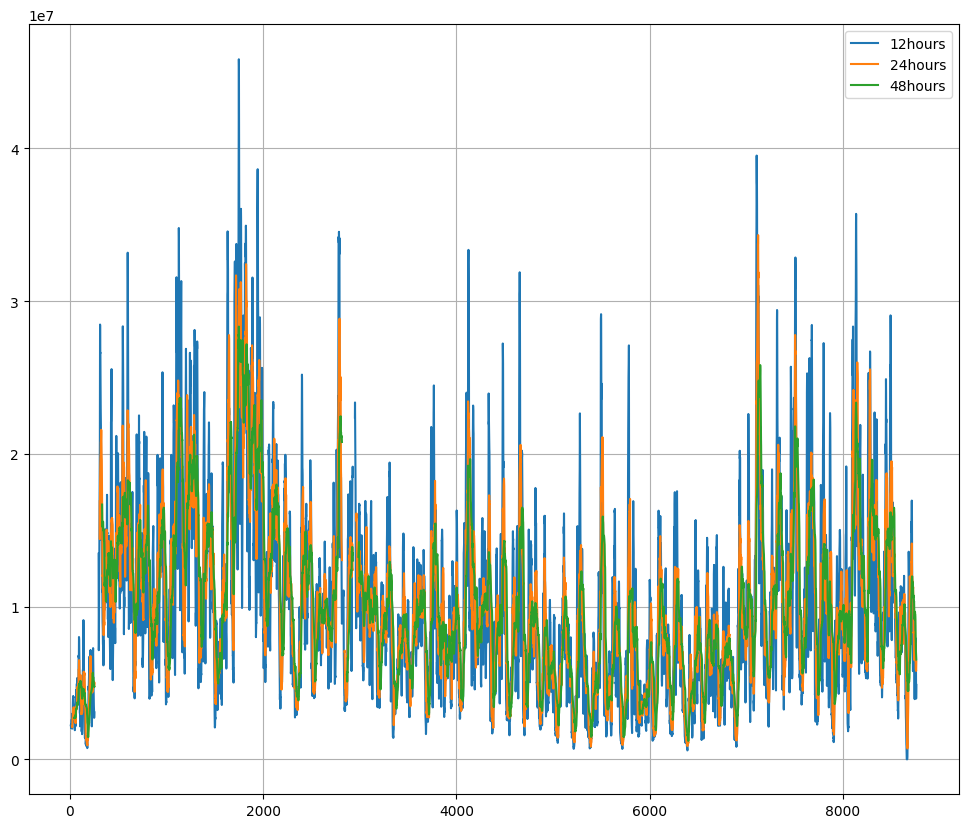

In [17]:
# 시각화
plt.figure(figsize = (12,10))
col = 'hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume'

for c in ['12hours', '24hours', '48hours']:
    plt.plot(
        pd.concat(
        [
            train_df[col],
            train_df[col].rolling(12).mean().rename(f"12hours"),
            train_df[col].rolling(24).mean().rename(f"24hours"),
            train_df[col].rolling(48).mean().rename(f"48hours")
        ], axis = 1)[c], label=str(c)
    )
plt.grid()
plt.legend()
plt.xticks()
plt.show()


=> 평균값으로 계산하면, width가 길수록 안정적이다. 중간값인 24시간으로 피처를 생성하도록 하겠다.

In [81]:
from typing import List
import pandas as pd

def rolling_feature(
   df: pd.DataFrame,
   conti_cols: List[str],
   intervals: List[int],
   funcs: List[str],
   min_periods: int,
   **params,
) -> pd.DataFrame:
   """
   Create rolling features
   Args:
       df (pd.DataFrame): Sorted dataframe
       conti_cols (List[str]): continuous colnames
       intervals (List[str]): rolling window widths
       funcs (List[str]): aggregation functions e.g. ["mean", "median", "max"]
       **params: more input for rolling
   Returns:
       pd.DataFrame
   """
   df_rolling_list = [
       df[conti_col]
       .rolling(interval, min_periods= min_periods, **params)
       .agg({f"{conti_col}": func})
       .rename({conti_col: f"{conti_col}_{func}_{interval}"}, axis=1)
       
       
       for conti_col in conti_cols
       for interval in intervals
       for func in funcs
   ]
   return pd.concat(df_rolling_list, axis=1)

In [84]:
# conti_cols : liquidation, taker_volume
# intervals : 24hours
# func : mean()

train_df = df.loc[df["_type"] == "train"]

conti_cols = [c for c in train_df.columns if 'volume' in c or 'liquidation' in c]
conti_cols = ['hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations',
       'hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd','hourly_market-data_liquidations_bybit_all_symbol_long_liquidations',
       'hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations',
       'hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_long_liquidations',
        'hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd',
       'hourly_market-data_liquidations_binance_btc_usdt_short_liquidations']

intervals = [24]
funcs = ["mean"]

# 초기 데이터는 이전 값이 주어지지 않으므로, min_periods = 1로 설정해 NaN값을 방지한다.
rolling_df = rolling_feature(train_df, conti_cols, intervals, funcs, 1)
rolling_df

,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24
0,2.015805e+06,1.411658e+06,7.663000e+05,1.610400e+06,3.772900e+05,2.525500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012000,197.516100,0.000000
1,3.024203e+06,1.292856e+06,8.611500e+05,1.385800e+06,4.205050e+05,1.847550e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5916.780520,0.006000,98.758050,0.356000
2,2.302000e+06,1.360154e+06,1.194100e+06,1.065567e+06,3.379333e+05,3.244767e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3944.520347,0.004000,65.838700,0.237333
3,2.035998e+06,1.237467e+06,1.133650e+06,1.040275e+06,2.975625e+05,2.932650e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2958.390260,0.151250,2488.071253,0.178000
4,2.113457e+06,1.553299e+06,1.143340e+06,1.014840e+06,2.640580e+05,3.101960e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2366.712208,0.193200,3179.344430,0.142400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,5.839264e+06,5.419129e+06,9.234767e+06,8.010475e+06,5.147249e+06,5.095539e+06,0.796875,33618.201433,1.158643,48646.770592,0.002275,96.000000,224062.051421,1.953375,82372.776391,5.228792
8756,5.828716e+06,5.312019e+06,9.279192e+06,7.966442e+06,5.157917e+06,5.077591e+06,0.736958,31135.888438,0.949888,39865.538900,0.002231,94.166667,235696.474302,1.702750,71940.482788,5.500500
8757,5.784857e+06,5.285992e+06,9.102867e+06,7.759250e+06,5.208412e+06,5.091745e+06,0.737083,31141.194500,0.949888,39865.538900,0.002231,94.166667,237853.846017,1.691542,71471.081911,5.550958
8758,6.115892e+06,6.234338e+06,9.409962e+06,8.428329e+06,5.266565e+06,5.111061e+06,0.883333,37347.457396,0.809456,34023.159713,0.002196,92.750000,244041.517126,3.035333,128359.242897,5.696375


In [85]:
train_df = pd.concat([train_df, rolling_df], axis=1)

## OverSampling
- SMOTE 기법을 적용해, 상대적으로 양이 적은 [0,3] 타겟의 데이터를 늘린다.

In [86]:
train_df['target'].value_counts()

target
2.0    3671
1.0    3544
3.0     805
0.0     740
Name: count, dtype: int64

In [87]:
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred",
    "hourly_network-data_fees-transaction_fees_transaction_median": "transaction_fee",
}

new_train_df = pd.concat([train_df[cols_dict.keys()].rename(cols_dict, axis=1), rolling_df], axis=1)
new_train_df

,ID,target,coinbase_premium_gap,tokens_transferred,transaction_fee,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,...,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24
0,2023-01-01 00:00:00,2.0,-9.86,0.020125,0.000014,2.015805e+06,1.411658e+06,7.663000e+05,1.610400e+06,3.772900e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012000,197.516100,0.000000
1,2023-01-01 01:00:00,1.0,-8.78,0.021293,0.000014,3.024203e+06,1.292856e+06,8.611500e+05,1.385800e+06,4.205050e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5916.780520,0.006000,98.758050,0.356000
2,2023-01-01 02:00:00,1.0,-9.59,0.022980,0.000014,2.302000e+06,1.360154e+06,1.194100e+06,1.065567e+06,3.379333e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3944.520347,0.004000,65.838700,0.237333
3,2023-01-01 03:00:00,1.0,-9.74,0.024678,0.000014,2.035998e+06,1.237467e+06,1.133650e+06,1.040275e+06,2.975625e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2958.390260,0.151250,2488.071253,0.178000
4,2023-01-01 04:00:00,2.0,-10.14,0.028596,0.000014,2.113457e+06,1.553299e+06,1.143340e+06,1.014840e+06,2.640580e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2366.712208,0.193200,3179.344430,0.142400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,1.0,-27.10,0.000620,0.000321,5.839264e+06,5.419129e+06,9.234767e+06,8.010475e+06,5.147249e+06,...,0.796875,33618.201433,1.158643,48646.770592,0.002275,96.000000,224062.051421,1.953375,82372.776391,5.228792
8756,2023-12-31 20:00:00,1.0,-24.73,0.001052,0.000292,5.828716e+06,5.312019e+06,9.279192e+06,7.966442e+06,5.157917e+06,...,0.736958,31135.888438,0.949888,39865.538900,0.002231,94.166667,235696.474302,1.702750,71940.482788,5.500500
8757,2023-12-31 21:00:00,0.0,-28.48,0.005020,0.000301,5.784857e+06,5.285992e+06,9.102867e+06,7.759250e+06,5.208412e+06,...,0.737083,31141.194500,0.949888,39865.538900,0.002231,94.166667,237853.846017,1.691542,71471.081911,5.550958
8758,2023-12-31 22:00:00,2.0,-9.08,0.009216,0.000350,6.115892e+06,6.234338e+06,9.409962e+06,8.428329e+06,5.266565e+06,...,0.883333,37347.457396,0.809456,34023.159713,0.002196,92.750000,244041.517126,3.035333,128359.242897,5.696375


In [88]:
x_train = new_train_df.drop(columns=['target','ID'])
y_train = new_train_df['target']

In [98]:
x_train['coinbase_premium_gap'].fillna(x_train['coinbase_premium_gap'].median(), inplace=True)
x_train[x_train.isna().any(axis=1)]

/tmp/ipykernel_311253/1078829136.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train['coinbase_premium_gap'].fillna(x_train['coinbase_premium_gap'].median(), inplace=True)


,coinbase_premium_gap,tokens_transferred,transaction_fee,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24


In [102]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(sampling_strategy={0.0:1000, 3.0:1000})

new_x_train, new_y_train = sampler.fit_resample(x_train, y_train)

new_y_train.value_counts()

target
2.0    3671
1.0    3544
3.0    1000
0.0    1000
Name: count, dtype: int64

In [105]:
new_x_train

,coinbase_premium_gap,tokens_transferred,transaction_fee,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume_mean_24,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_huobi_global_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_mean_24,hourly_market-data_liquidations_bybit_all_symbol_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usd_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_mean_24,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd_mean_24,hourly_market-data_liquidations_binance_btc_usdt_short_liquidations_mean_24
0,-9.860000,0.020125,0.000014,2.015805e+06,1.411658e+06,7.663000e+05,1.610400e+06,3.772900e+05,2.525500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012000,197.516100,0.000000
1,-8.780000,0.021293,0.000014,3.024203e+06,1.292856e+06,8.611500e+05,1.385800e+06,4.205050e+05,1.847550e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5916.780520,0.006000,98.758050,0.356000
2,-9.590000,0.022980,0.000014,2.302000e+06,1.360154e+06,1.194100e+06,1.065567e+06,3.379333e+05,3.244767e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3944.520347,0.004000,65.838700,0.237333
3,-9.740000,0.024678,0.000014,2.035998e+06,1.237467e+06,1.133650e+06,1.040275e+06,2.975625e+05,2.932650e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2958.390260,0.151250,2488.071253,0.178000
4,-10.140000,0.028596,0.000014,2.113457e+06,1.553299e+06,1.143340e+06,1.014840e+06,2.640580e+05,3.101960e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2366.712208,0.193200,3179.344430,0.142400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9210,10.334167,0.014475,0.000028,1.187021e+07,1.004022e+07,7.506707e+06,7.623263e+06,4.234157e+06,4.277548e+06,1.572746,34461.683896,5.351434,115975.104156,0.009453,205.588562,133721.066109,2.617932,57550.013477,6.087311
9211,-20.195007,0.006039,0.000261,1.853054e+07,1.871715e+07,2.919475e+07,2.966431e+07,1.754096e+07,1.709733e+07,3.686856,151973.557622,6.363693,261333.550387,0.027997,1149.659809,404406.605297,6.729861,279214.157816,9.525149
9212,7.099788,0.015360,0.000304,1.549497e+07,1.645004e+07,1.752273e+07,1.689055e+07,1.282056e+07,1.138621e+07,1.453769,55821.381597,7.166053,286946.544149,0.015642,578.366088,325067.273477,3.832071,148885.234748,7.967784
9213,14.334082,0.001723,0.000118,1.171985e+07,1.113675e+07,1.540977e+07,1.547974e+07,1.297484e+07,1.452968e+07,1.524957,65770.497892,2.227371,95698.290752,0.006996,301.910233,271198.940374,4.351043,187688.042908,6.204203


In [122]:
### Model Training
from xgboost import XGBClassifier

# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    new_x_train, 
    new_y_train.astype(int), 
    test_size=0.2,
    random_state=42,
)

bst = XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, objective='multi:softmax', eval_metric=['merror','mlogloss'])

# train
bst.fit(x_train, y_train)

# predict
y_valid_pred = bst.predict(x_valid)
y_valid_proba = bst.predict_proba(x_valid)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred)
auroc = roc_auc_score(y_valid, y_valid_proba, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

# performance 체크후 전체 학습 데이터로 다시 재학습
#train_data = lgb.Dataset(new_x_train, label=new_y_train)
bst_model = bst.fit(
    new_x_train, new_y_train
)

acc: 0.38252848616386326, auroc: 0.6252404463656142
